## 赛事介绍
实时对战游戏是人工智能研究领域的一个热点。由于游戏复杂性、部分可观察和动态实时变化战局等游戏特点使得研究变得比较困难。我们可以在选择英雄阶段预测胜负概率，也可以在比赛期间根据比赛实时数据进行建模。那么我们英雄联盟对局进行期间，能知道自己的胜率吗？

![](https://ai-studio-static-online.cdn.bcebos.com/9739d3ca3cef4e32989a541af450a9556e91bf89a4e946e0a856cc2424321638)


## 赛事任务
比赛数据使用了英雄联盟玩家的实时游戏数据，记录下用户在游戏中对局数据（如击杀数、住物理伤害）。希望参赛选手能从数据集中挖掘出数据的规律，并预测玩家在本局游戏中的输赢情况。

赛题训练集案例如下：
- 训练集18万数据；
- 测试集2万条数据；

```plain
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv.zip')
```

对于数据集中每一行为一个玩家的游戏数据，数据字段如下所示：

* id：玩家记录id
* win：是否胜利，标签变量
* kills：击杀次数
* deaths：死亡次数
* assists：助攻次数
* largestkillingspree：最大 killing spree（游戏术语，意味大杀特杀。当你连续杀死三个对方英雄而中途没有死亡时）
* largestmultikill：最大mult ikill（游戏术语，短时间内多重击杀）
* longesttimespentliving：最长存活时间
* doublekills：doublekills次数
* triplekills：doublekills次数
* quadrakills：quadrakills次数
* pentakills：pentakills次数
* totdmgdealt：总伤害
* magicdmgdealt：魔法伤害
* physicaldmgdealt：物理伤害
* truedmgdealt：真实伤害
* largestcrit：最大暴击伤害
* totdmgtochamp：对对方玩家的伤害
* magicdmgtochamp：对对方玩家的魔法伤害
* physdmgtochamp：对对方玩家的物理伤害
* truedmgtochamp：对对方玩家的真实伤害
* totheal：治疗量
* totunitshealed：痊愈的总单位
* dmgtoturrets：对炮塔的伤害
* timecc：法控时间
* totdmgtaken：承受的伤害
* magicdmgtaken：承受的魔法伤害
* physdmgtaken：承受的物理伤害
* truedmgtaken：承受的真实伤害
* wardsplaced：侦查守卫放置次数
* wardskilled：侦查守卫摧毁次数
* firstblood：是否为firstblood

测试集中label字段win为空，需要选手预测。

##  评审规则

1. 数据说明

选手需要提交测试集队伍排名预测，具体的提交格式如下：

```plain
win
0
1
1
0
```

 2. 评估指标

本次竞赛的使用准确率进行评分，数值越高精度越高，评估代码参考：

```
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
accuracy_score(y_true, y_pred)
```

# 四川省高校暑期实训挑战第11名方案

## 数据集处理

通过查看数据集，发现法控时间（timecc）、五杀（pentakills）这两种数据，其中法控时间均为0，五杀数据几乎没有大于0的，因此可以删掉这两个数据字段。

在游戏中，会使用KDA来评价游戏玩家本局的水平，因此添加了新的字段KDA，KDA=(K+A)/D（如果D为0，则除以1）。此外，视野也是影响游戏胜利的一部分。wardsplaced（侦查守卫放置次数）和wardskilled（侦查守卫摧毁次数）都是属于视野方面的一部分，因此可以新加一个关于视野的数据字段wardsgrade（事业得分），wardsgrade=wardsplaced+wardskilled

## 模型训练

在训练模型前，对参数做一些测试后，最后还是选择了学习率为0.01的。

在训练模型前，考虑到数据集分为三种：训练集，验证集，测试集。因此，18万数据中，将最后2万的数据作为验证集。

```python
# 从第0行到倒数20000行（不包括），设置为training_data
training_data = train_df.iloc[:-20000,].values.astype(np.float32)
# 从倒数20000行到最后一行设置为val_data
val_data = train_df.iloc[-20000:, ].values.astype(np.float32)
```

去掉了训练轮次，改为了验证集用于验证。即：在一个无尽循环中，每训练完成一次，就使用验证集验证一次，如果此次的准确率大于0.85，且训练轮次大于200，该训练结束。

```python
if correct/len(a)>0.85 and epoch_number>200:
	print("final: ",correct/len(a),' epoch_number: ',epoch_number,' max: ',max)
	break
```

由于模型一直训练，两个要求都没有达到，所以在1150轮前时候停止，此时最佳的效果为0.8467，然后使用测试集测试，得出了最高的分数83.93。

![最高分](https://cyan-1305222096.cos.ap-nanjing.myqcloud.com/%E6%9C%80%E9%AB%98%E5%88%86.png)

## 一些失败的尝试

在数据集处理时，发现此处的处理有些问题，例如，如果在训练集中kills（击杀次数）最大为60，在测试集中的最大kills为30，在训练集中有一个id为A的玩家击杀次数为30，在测试机中的一个id为B的玩家击杀次数为15。通过数据可以直观地看出二者的差距，但是在经过以下代码处理后，`train_df['kills']['A']`和`test_df['kills']['B']`的值更新后都是0.5。因此以下的代码并不能准确地体现不同的数据集上的玩家的真实水平。

```python
# 将每一列的数据全部转化为比例
for col in train_df.columns[1:]:
    train_df[col] /= train_df[col].max()
    test_df[col] /= test_df[col].max()
print(train_df)
```

此外，还考虑到异常值的处理，如果在训练集中kills的值普遍在50以下，但是有一个异常值为80，那么上述代码则会减小不同数据的差距，例如两个玩家的kills为10和20，算出的比例为1/8和1/4，而如果选用50作为除数，则比例为1/5和2/5，二者差异更大。如何选择合理的除数，是一个关键问题。

![下载](https://cyan-1305222096.cos.ap-nanjing.myqcloud.com/%E4%B8%8B%E8%BD%BD.png)

在代码运行时，注意到了箱型图的结构，有上下四分位数和上下边缘，其中的上边缘正好适合需求，于是，通过函数构造，获得了每列的上边缘值。

```python
#计算上下四分位数
def count_quartiles(lis):
    q1 = lis[int(1 + (float(len(lis)) - 1) * 1 / 4)]
    q3 = lis[int(1 + (float(len(lis)) - 1) * 3 / 4)]
    return q1, q3

#计算上下边缘
def count_margin(q1, q3):
    q4 = q3 + 1.5 * (q3 - q1)
    q5 = q1 - 1.5 * (q3 - q1)
    return q4, q5
# 获取列名
def upper_limit(df):
    columns = df.columns.values.tolist()  #列名
    print(columns)
    upper_limit_values = []
    for column in columns:
        sort_df = df.sort_values(by=column)
        q1,q3 = count_quartiles(list(sort_df[column]))
        column_upper=count_margin(q1,q3)[0]
        upper_limit_values.append(column_upper)
        print(upper_limit_values)
    return upper_limit_values

upper_limit_values_train_df=upper_limit(train_df)
del(upper_limit_values_train_df[0])
upper_limit_values_test_df=upper_limit(test_df)
```

对于训练数据集，需要删除win字段，而测试集则不需要。

以上二者的数据处理，在模型训练完成，提交结果后的成绩并不理想，因此以上的尝试也以失败告终。

## Baseline使用指导
1、点击‘fork按钮’，出现‘fork项目’弹窗         
2、点击‘创建按钮’ ，出现‘运行项目’弹窗    
3、点击‘运行项目’，自动跳转至新页面      
4、点击‘启动环境’ ，出现‘选择运行环境’弹窗     
5、选择运行环境（启动项目需要时间，请耐心等待），出现‘环境启动成功’弹窗，点击确定        
6、点击进入环境，即可进入notebook环境      
7、鼠标移至下方每个代码块内（代码块左侧边框会变成浅蓝色），再依次点击每个代码块左上角的‘三角形运行按钮’，待一个模块运行完以后再运行下一个模块，直至全部运行完成  
![](https://ai-studio-static-online.cdn.bcebos.com/226c72f88f5b4e9d8a55e59129e4c79770aa200f10ef413ca1420ae7d273bc88)  
![](https://ai-studio-static-online.cdn.bcebos.com/866a22a341d64166aaf9a8a3abee09b5a6e2d0cba1c649bb8bdef6b2ad7955f1)  
8、下载页面左侧submission.zip压缩包  
![](https://ai-studio-static-online.cdn.bcebos.com/b7f3076301e34462abaf2013dcdbf10a5dcbfe287d5845f1869493e578391f7a)  
9、在比赛页提交submission.zip压缩包，等待系统评测结束后，即可登榜！    
![](https://ai-studio-static-online.cdn.bcebos.com/95a9fc4140144a2d8a76258f7a536751c5c6969994154d3da71c80e23757c6c8)  
10、点击页面左侧‘版本-生成新版本’  
![](https://ai-studio-static-online.cdn.bcebos.com/e62d0f5ca1454f7485c3eb1351823315480356cafad143c2ab2ff065f95104fe)  
11、填写‘版本名称’，点击‘生成版本按钮’，即可在个人主页查看到该项目（可选择公开此项目哦）  

In [ ]:
import pandas as pd
import paddle
import numpy as np
%pylab inline
import seaborn as sns

# 读取train和test的文件，返回的dataframe的数据结构
train_df = pd.read_csv('data/data137276/train.csv.zip')
test_df = pd.read_csv('data/data137276/test.csv.zip')

# 删除列id和timecc（法控时间）以及五杀
train_df = train_df.drop(['id','timecc','pentakills'], axis=1)
test_df = test_df.drop(['id','timecc','pentakills'], axis=1)
# train_df = train_df.drop(['id','timecc','pentakills','magicdmgtochamp','physdmgtochamp','truedmgtochamp','magicdmgtaken','physdmgtaken','truedmgtaken'], axis=1)
# test_df = test_df.drop(['id','timecc','pentakills','magicdmgtochamp','physdmgtochamp','truedmgtochamp','magicdmgtaken','physdmgtaken','truedmgtaken'], axis=1)

Populating the interactive namespace from numpy and matplotlib


## 数据分析

In [ ]:
# 计算每列数据的缺失率
train_df.isnull().mean(0)

win                       0.0
kills                     0.0
deaths                    0.0
assists                   0.0
largestkillingspree       0.0
largestmultikill          0.0
longesttimespentliving    0.0
doublekills               0.0
triplekills               0.0
quadrakills               0.0
totdmgdealt               0.0
magicdmgdealt             0.0
physicaldmgdealt          0.0
truedmgdealt              0.0
largestcrit               0.0
totdmgtochamp             0.0
magicdmgtochamp           0.0
physdmgtochamp            0.0
truedmgtochamp            0.0
totheal                   0.0
totunitshealed            0.0
dmgtoturrets              0.0
totdmgtaken               0.0
magicdmgtaken             0.0
physdmgtaken              0.0
truedmgtaken              0.0
wardsplaced               0.0
wardskilled               0.0
firstblood                0.0
dtype: float64

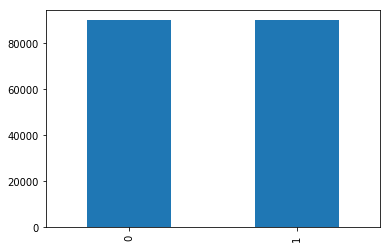

In [ ]:
# 查看win列的数据，以条形统计图形式展现
train_df['win'].value_counts().plot(kind='bar')

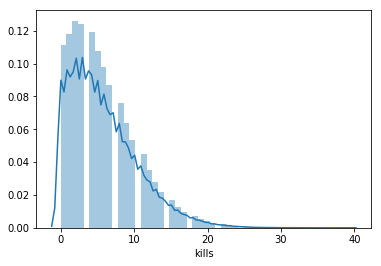

In [ ]:
# 展示条形图和核密度统计图
sns.distplot(train_df['kills'])

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/distributions.py:179: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.asarray(a, np.float)


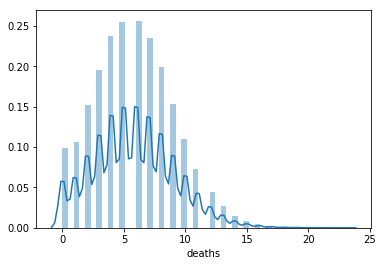

In [ ]:
# 展示死亡率
sns.distplot(train_df['deaths'])

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/categorical.py:340: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/utils.py:538: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float

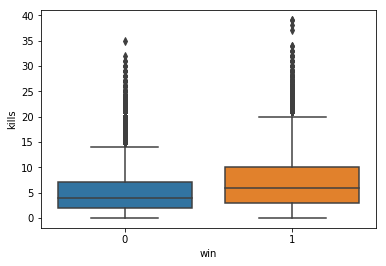

In [ ]:
# 箱型图
# 箱型图链接：https://blog.csdn.net/Artoria_QZH/article/details/102790740?spm=1001.2101.3001.6650.1&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1-102790740-blog-115874925.pc_relevant_multi_platform_whitelistv1&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1-102790740-blog-115874925.pc_relevant_multi_platform_whitelistv1&utm_relevant_index=2
sns.boxplot(y='kills', x='win', data=train_df)
# 箱型图结论：win的时候kills更多

Text(0,0.5,'deaths')

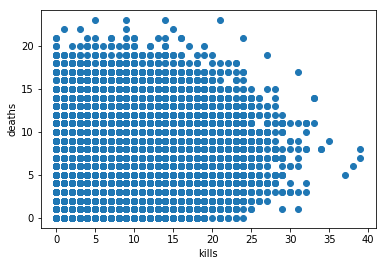

In [ ]:
# 散点图
# kill与death的对应关系
plt.scatter(train_df['kills'], train_df['deaths'])
plt.xlabel('kills')
plt.ylabel('deaths')

In [ ]:
# 视野得分
def wardsgrade(df):
    df['wardsgrade']=0
    for i in range(len(df)):
        # 获取wardsplaced和wardskilled值
        wardsplaced = df['wardsplaced'][i]
        wardskilled = df['wardskilled'][i]
        df['wardsgrade']= wardsplaced + wardskilled
        print(f'{i}')
wardsgrade(train_df)
wardsgrade(test_df)

In [ ]:
def kda(df):
    df['kda']=0.0
    for i in range(len(df)):
        # 获取K、D、A的值
        kill = df['kills'][i]
        death = df['deaths'][i]
        assists = df['assists'][i]
        if death != 0:
            kda = (kill+assists)/death
        else:
            kda = kill+assists
        df['kda'][i]=kda
        print(f'{i}:{kill}/{death}/{assists}/{kda}')
    return df

kda(train_df)
kda(test_df)

0:1/5/2/0.6
1:5/8/7/1.5
2:1/6/16/2.8333333333333335
3:1/2/0/0.5
4:4/11/25/2.6363636363636362
5:8/6/10/3.0
6:4/12/9/1.0833333333333333
7:4/7/8/1.7142857142857142
8:3/6/11/2.3333333333333335
9:11/1/5/16.0
10:11/6/12/3.8333333333333335
11:4/5/6/2.0
12:8/6/11/3.1666666666666665
13:5/7/3/1.1428571428571428
14:4/20/21/1.25
15:7/3/6/4.333333333333333
16:0/7/2/0.2857142857142857
17:10/10/12/2.2
18:2/6/18/3.3333333333333335
19:0/6/7/1.1666666666666667
20:3/8/6/1.125
21:7/3/5/4.0
22:4/2/7/5.5
23:12/3/7/6.333333333333333
24:0/6/11/1.8333333333333333
25:6/3/4/3.3333333333333335
26:4/11/5/0.8181818181818182
27:5/8/3/1.0
28:12/9/8/2.2222222222222223
29:1/5/2/0.6
30:1/3/4/1.6666666666666667
31:6/7/2/1.1428571428571428
32:3/4/3/1.5
33:0/3/13/4.333333333333333
34:12/4/10/5.5
35:10/7/8/2.5714285714285716
36:0/4/8/2.0
37:0/3/3/1.0
38:13/9/10/2.5555555555555554
39:4/8/2/0.75
40:10/2/8/9.0
41:5/14/22/1.9285714285714286
42:6/2/7/6.5
43:0/0/0/0
44:4/9/6/1.1111111111111112
45:11/17/18/1.7058823529411764
46:4/

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


568:16/5/5/4.2
569:9/11/6/1.3636363636363635
570:21/3/15/12.0
571:1/7/4/0.7142857142857143
572:10/3/6/5.333333333333333
573:9/2/5/7.0
574:5/6/7/2.0
575:2/12/6/0.6666666666666666
576:7/3/15/7.333333333333333
577:0/0/0/0
578:1/2/6/3.5
579:1/7/23/3.4285714285714284
580:4/1/9/13.0
581:8/12/31/3.25
582:2/10/10/1.2
583:1/5/16/3.4
584:1/8/15/2.0
585:6/1/10/16.0
586:0/3/8/2.6666666666666665
587:3/12/9/1.0
588:5/10/14/1.9
589:2/8/2/0.5
590:25/13/26/3.923076923076923
591:6/2/0/3.0
592:4/8/10/1.75
593:6/6/5/1.8333333333333333
594:0/1/1/1.0
595:9/0/11/20
596:12/7/10/3.142857142857143
597:1/4/4/1.25
598:8/4/7/3.75
599:8/3/10/6.0
600:5/0/7/12
601:3/6/18/3.5
602:8/3/15/7.666666666666667
603:7/9/11/2.0
604:0/2/13/6.5
605:0/10/6/0.6
606:3/7/3/0.8571428571428571
607:0/5/1/0.2
608:3/5/13/3.2
609:4/3/23/9.0
610:9/15/14/1.5333333333333334
611:12/9/28/4.444444444444445
612:3/2/12/7.5
613:8/0/1/9
614:4/8/4/1.0
615:4/9/2/0.6666666666666666
616:6/5/3/1.8
617:0/0/0/0
618:2/5/11/2.6
619:2/9/18/2.2222222222222223

,kills,deaths,assists,largestkillingspree,largestmultikill,longesttimespentliving,doublekills,triplekills,quadrakills,totdmgdealt,...,dmgtoturrets,totdmgtaken,magicdmgtaken,physdmgtaken,truedmgtaken,wardsplaced,wardskilled,firstblood,wardsgrade,kda
0,8,7,5,2,1,874,0,0,0,143764,...,0,20112,6704,12945,462,10,3,0,65,1.857143
1,4,8,5,2,1,978,0,0,0,208763,...,4974,49389,19109,29651,629,15,2,0,65,1.125000
2,19,6,8,10,2,912,5,0,0,192145,...,5653,26606,8344,17627,634,14,2,0,65,4.500000
3,1,8,6,0,1,519,0,0,0,137372,...,3988,25852,5111,19552,1189,5,3,0,65,0.875000
4,1,10,12,0,1,646,0,0,0,50707,...,465,34486,16690,16882,914,39,9,0,65,1.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2,9,28,0,1,886,0,0,0,26097,...,1081,34860,14476,19691,692,22,1,0,65,3.333333
19996,1,2,2,0,1,383,0,0,0,95875,...,478,15828,1375,14404,48,8,0,0,65,1.500000
19997,2,9,4,0,1,387,0,0,0,86547,...,0,22255,4189,16467,1598,0,0,1,65,0.666667
19998,0,5,0,0,0,381,0,0,0,47119,...,1285,11519,4679,6839,0,4,0,0,65,0.000000


In [ ]:
# 不运行
print(type(train_df['kda'][2]))

<class 'numpy.float64'>


In [ ]:
# 不运行
#计算上下四分位数
def count_quartiles(lis):
    q1 = lis[int(1 + (float(len(lis)) - 1) * 1 / 4)]
    q3 = lis[int(1 + (float(len(lis)) - 1) * 3 / 4)]
    return q1, q3

#计算上下边缘
def count_margin(q1, q3):
    q4 = q3 + 1.5 * (q3 - q1)
    q5 = q1 - 1.5 * (q3 - q1)
    return q4, q5

In [ ]:
# 不运行

# 获取列名
def upper_limit(df):
    columns = df.columns.values.tolist()  #列名
    print(columns)
    upper_limit_values = []
    for column in columns[1:]:
        sort_df = df.sort_values(by=column)
        q1,q3 = count_quartiles(list(sort_df[column]))
        column_upper=count_margin(q1,q3)[0]
        upper_limit_values.append(column_upper)
        print(upper_limit_values)
    print(upper_limit_values)

upper_limit(train_df)



['win', 'kills', 'deaths', 'assists', 'largestkillingspree', 'largestmultikill', 'longesttimespentliving', 'doublekills', 'triplekills', 'quadrakills', 'totdmgdealt', 'magicdmgdealt', 'physicaldmgdealt', 'truedmgdealt', 'largestcrit', 'totdmgtochamp', 'totheal', 'totunitshealed', 'dmgtoturrets', 'totdmgtaken', 'wardsplaced', 'wardskilled', 'firstblood', 'kda']
[17.0]
[17.0, 15.5]
[17.0, 15.5, 24.0]
[17.0, 15.5, 24.0, 10.0]
[17.0, 15.5, 24.0, 10.0, 3.5]
[17.0, 15.5, 24.0, 10.0, 3.5, 1330.5]
[17.0, 15.5, 24.0, 10.0, 3.5, 1330.5, 2.5]
[17.0, 15.5, 24.0, 10.0, 3.5, 1330.5, 2.5, 0.0]
[17.0, 15.5, 24.0, 10.0, 3.5, 1330.5, 2.5, 0.0, 0.0]
[17.0, 15.5, 24.0, 10.0, 3.5, 1330.5, 2.5, 0.0, 0.0, 304004.0]
[17.0, 15.5, 24.0, 10.0, 3.5, 1330.5, 2.5, 0.0, 0.0, 304004.0, 138529.0]
[17.0, 15.5, 24.0, 10.0, 3.5, 1330.5, 2.5, 0.0, 0.0, 304004.0, 138529.0, 267128.5]
[17.0, 15.5, 24.0, 10.0, 3.5, 1330.5, 2.5, 0.0, 0.0, 304004.0, 138529.0, 267128.5, 17053.5]
[17.0, 15.5, 24.0, 10.0, 3.5, 1330.5, 2.5, 0.0, 0.

In [ ]:
# 不运行

sort_df = train_df.sort_values(by="kda")
# print(list(sort_df['kda']))
print(train_df['kda'])

0         0.600000
1         1.500000
2         2.833333
3         0.500000
4         2.636364
            ...   
179995    0.000000
179996    0.000000
179997    0.000000
179998    0.000000
179999    0.000000
Name: kda, Length: 180000, dtype: float64


In [ ]:
# 将每一列的数据全部转化为比例
# 此处可以改进，原因为：除以最大值-未改进

for col in train_df.columns[1:]:
    train_df[col] /= train_df[col].max()
    test_df[col] /= test_df[col].max()
print(train_df)

        win     kills    deaths   assists  largestkillingspree  \
0         0  0.025641  0.217391  0.038462             0.000000   
1         0  0.128205  0.347826  0.134615             0.096774   
2         1  0.025641  0.260870  0.307692             0.000000   
3         0  0.025641  0.086957  0.000000             0.000000   
4         0  0.102564  0.478261  0.480769             0.000000   
...     ...       ...       ...       ...                  ...   
179995    1  0.025641  0.260870  0.230769             0.000000   
179996    1  0.179487  0.130435  0.076923             0.161290   
179997    1  0.230769  0.000000  0.173077             0.290323   
179998    1  0.358974  0.043478  0.096154             0.322581   
179999    1  0.102564  0.173913  0.038462             0.064516   

        largestmultikill  longesttimespentliving  doublekills  triplekills  \
0                    0.2                0.187294     0.000000          0.0   
1                    0.2                0.289664   

## 搭建模型

In [ ]:
# 创建分类器
class Classifier(paddle.nn.Layer):
    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Classifier, self).__init__()
        
        self.fc1 = paddle.nn.Linear(in_features=28, out_features=40)
        self.fc2 = paddle.nn.Linear(in_features=40, out_features=1)
        self.relu = paddle.nn.ReLU()
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.relu(self.fc1(inputs))
        x = self.fc2(x)
        return x

In [ ]:
# 创建模型
model = Classifier()
model.train()
# https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/optimizer/SGD_cn.html#cn-api-paddle-optimizer-sgd
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
loss_fn = paddle.nn.BCEWithLogitsLoss()

In [ ]:
# 不运行
# 测试
# EPOCH_NUM = 100   # 设置外层循环次数
BATCH_SIZE = 100  # 设置batch大小
# 从第0行到倒数1000行（不包括），设置为training.data
# print(train_df)
training_data = train_df.iloc[:-10000,].values.astype(np.float32)
# print(training_data)
# 从倒数1000行到最后一行,设置为val_data
val_data = train_df.iloc[-1000:, ].values.astype(np.float32)
# 将训练数据进行拆分，每个batch包含10条数据
mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
i= 1
for iter_id, mini_batch in enumerate(mini_batches):
    x = np.array(mini_batch[:, 1:]) # 获得当前批次训练数据
    y = np.array(mini_batch[:, :1]) # 获得当前批次训练标签
    i=i+1
    if i<10:
        print(y)
        print(1)

In [ ]:
# train_df = train_df.drop(['wardsplaced','wardskilled'], axis=1)
# test_df = test_df.drop(['wardsplaced','wardskilled'], axis=1)

In [73]:
# EPOCH_NUM = 200  # 设置外层循环次数
BATCH_SIZE = 200  # 设置batch大小
# 从第0行到倒数1000行（不包括），设置为training.data
training_data = train_df.iloc[:-20000,].values.astype(np.float32)
# 从倒数1000行到最后一行设置为val_data
val_data = train_df.iloc[-20000:, ].values.astype(np.float32)
epoch_number = 0
max = 0
# 定义外层循环，每一轮循环中
while(True):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    np.random.shuffle(val_data)
    epoch_number = epoch_number+1
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
         # 获得当前批次训练数据，x是除了win之外的其他数据
        x = np.array(mini_batch[:, 1:])
        y = np.array(mini_batch[:, :1]) # 获得当前批次训练标签，win值
        
        # 将numpy数据转为飞桨动态图tensor的格式
        features = paddle.to_tensor(x)
        y = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(features)
        
        # 计算损失
        loss = loss_fn(predicts, y, )
        # 计算平均
        avg_loss = paddle.mean(loss)
        if iter_id%200==0:
            acc = (predicts > 0).astype(int).flatten() == y.flatten().astype(int)
            acc = acc.astype(float).mean()

            print("epoch: {}, iter: {}, loss is: {}, acc is {}".format(epoch_number, iter_id, avg_loss.numpy(), acc.numpy()))
        
        # 反向传播，计算每层参数的梯度值
        avg_loss.backward()
        # 更新参数，根据设置好的学习率迭代一步
        opt.step()
        # 清空梯度变量，以备下一轮计算
        opt.clear_grad()
    # 使用验证集
    model.eval()
    test_predict = model(paddle.to_tensor(val_data[:, 1:]))
    test_predict = (test_predict > 0).astype(int).flatten()
    a = pd.DataFrame({'win':
              test_predict.numpy()
             })
    correct = 0
    
    for i in range(len(a)):
        if int(a['win'][i])== int(val_data[:,:1][i][0]):
            correct=correct+1
    correct_percent = correct/len(a)
    if max<correct_percent:
        max = correct_percent
    print("validation percent: ",correct_percent,' max: ',max)
    if correct/len(a)>0.85 and epoch_number>200:
        print("final: ",correct/len(a),' epoch_number: ',epoch_number,' max: ',max)
        break
# 

KeyboardInterrupt: 

In [74]:
# 不运行

print(max)

0.8467


In [75]:
# 不运行

# 使用验证集
model.eval()
val_data = train_df.iloc[-20000:, ].values.astype(np.float32)
test_data = paddle.to_tensor(val_data[:, 1:])
# print(test_data)
test_predict = model(test_data)
test_predict = (test_predict > 0).astype(int).flatten()
print(type(val_data[:,:1][1]))
print(type(test_predict))
a = pd.DataFrame({'win':
              test_predict.numpy()
             })
print(len(a))
print(type(a['win'][1]))
correct = 0
for i in range(len(a)):
    if int(a['win'][i])== int(val_data[:,:1][i][0]):
        correct=correct+1
print(correct/len(a))

<class 'numpy.ndarray'>
<class 'paddle.Tensor'>
20000
<class 'numpy.longlong'>
0.84545


In [76]:
print(type(test_predict))
a = pd.DataFrame({'win':
              test_predict.numpy()
             })
print(len(a))
print(type(a['win'][1]))
correct = 0
for i in range(len(a)):
    if int(a['win'][i])== int(val_data[:,:1][i][0]):
        correct=correct+1
print(correct/len(a))

<class 'paddle.Tensor'>
20000
<class 'numpy.longlong'>
0.84545


In [77]:
# 原来的代码
model.eval()
test_data = paddle.to_tensor(test_df.values.astype(np.float32))
test_predict = model(test_data)
test_predict = (test_predict > 0).astype(int).flatten()

In [78]:
pd.DataFrame({'win':
              test_predict.numpy()
             }).to_csv('submission.csv', index=None)

!zip submission.zip submission.csv

updating: submission.csv (deflated 90%)


## 总结与上分点

1. 原始赛题字段存在关联，可以进一步提取交叉特征。
2. 模型训练过程中可以加入验证集验证过程。